# Open Ocean
# Open Earth Fundation
---------------------------------------------------------------------------------------------------------------------
Authors: Margaux Filippi & Maureen Fonseca

---------------------------------------------------------------------------------------------------------------------

<h1> Calculating and comparing marine biodiversity metrics for ACMC </h1>

This series of notebooks aims to calculate different marine biodiversity indices, such as:
- WEGE
- STAR
- other Marine Biodiversity Units

for a few areas around Cocos Island, Costa Rica:
- AMMB, or Área Marina de Manejo del Bicentenario (marine protected area that got extended for the bicentennial)
- PNIC, or Parque National de Isla del Coco (Cocos Island national park)
- ACMC, or Area de Conservación Marina Coco (AMMB + PNIC)

We will later extend to the Eastern Tropical Pacific. The data source that we use is UICN.

<h1> Step 2: calculate different metrics </h1>

This notebook shows the second step, the data analysis.

<h2> Data needed for this project </h2>

The data was output by `ACMC_IUCN_step1_curatedata.ipynb` and can be found under [IUCN_RedList](https://drive.google.com/drive/folders/1nkw8VK9mPdthjyDOSsnljqCo_b7lMdP4?usp=sharing) under a temporary folder that accompagnies the GitHub repository: 

`Ocean Program > data > to download for gh > ACMC_IUCN_data`

### Analyzing UICN data for marine species in the Eastern Tropical Pacific.

In [1]:
import geopandas as gpd

/Users/maureenfonseca/opt/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
import numpy as np
import pandas as pd

In [3]:
import os
import glob

In [4]:
from shapely.geometry import Polygon, Point

In [5]:
import fiona; #help(fiona.open)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import timeit

In [129]:
from netCDF4 import Dataset
import cmocean
import geopandas as gpd
from matplotlib.ticker import LinearLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

OEF functions

In [8]:
from marinebiodiversity_utils import *

<h1> 1. Load data </h1>

<h2> 1.1 Get the conservation area</h2>

Mostly for plotting.

<h3> Coordinates for Cocos Island </h3>

Cocos Island is located at 05°31′41″N; 87°03′40″W

In [9]:
Cocos_lat = 5+31/60+41/3600
Cocos_lon = -(87+3/60+40/3600)
Cocos = Point(Cocos_lon, Cocos_lat)

<h3> Import entire AMMB and PNIC </h3>

In [10]:
ACMC = gpd.read_file('../../Geospatial_ACMC/ACMC.shp')
AMMB = gpd.read_file('../../Geospatial_ACMC/AMMB.shp')
PNIC = gpd.read_file('../../Geospatial_ACMC/PNIC.shp')

Inspect the Coordinate Reference Systems (CRS).

In [11]:
AMMB.crs

<Derived Projected CRS: EPSG:5367>
Name: CR05 / CRTM05
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Costa Rica - onshore and offshore east of 86°30'W.
- bounds: (-86.5, 2.21, -81.43, 11.77)
Coordinate Operation:
- name: Costa Rica TM 2005
- method: Transverse Mercator
Datum: Costa Rica 2005
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
PNIC.crs

<Derived Projected CRS: EPSG:5367>
Name: CR05 / CRTM05
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Costa Rica - onshore and offshore east of 86°30'W.
- bounds: (-86.5, 2.21, -81.43, 11.77)
Coordinate Operation:
- name: Costa Rica TM 2005
- method: Transverse Mercator
Datum: Costa Rica 2005
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
AMMB_WGS84 = AMMB.to_crs(crs=4326)
PNIC_WGS84 = PNIC.to_crs(crs=4326)
ACMC = ACMC.set_crs(epsg=4326, allow_override=True)

In [14]:
ACMC['area']

0    1.062837e+07
Name: area, dtype: float64

Get area information.

In [15]:
print("Area, PNIC:")
print("{:0.2f}".format(PNIC_WGS84.area.item()) + " sqdeg.")
print("{:,.2f}".format(PNIC_WGS84.to_crs(crs=31970).area.item()*10**(-6)) + " sqkm in CRS 31970.")

print("\nArea, AMMB:")
print("{:0.2f}".format(AMMB_WGS84.area.item()) + " sqdeg.")
print("{:,.2f}".format(AMMB_WGS84.to_crs(crs=31970).area.item()*10**(-6)) + " sqkm in CRS 31970.")

print("\nTotal Area, ACMC:")
print("{:0.2f}".format(AMMB_WGS84.area.item() + PNIC_WGS84.area.item()) + " sqdeg.")
print("{:,.2f}".format(AMMB_WGS84.to_crs(crs=31970).area.item()*10**(-6) + PNIC_WGS84.to_crs(crs=31970).area.item()*10**(-6)) + " sqkm in CRS 31970.")

Area, PNIC:
4.47 sqdeg.
54,799.50 sqkm in CRS 31970.

Area, AMMB:
8.66 sqdeg.
106,243.90 sqkm in CRS 31970.

Total Area, ACMC:
13.13 sqdeg.
161,043.41 sqkm in CRS 31970.


/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/2915868912.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print("{:0.2f}".format(PNIC_WGS84.area.item()) + " sqdeg.")
/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/2915868912.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print("{:0.2f}".format(AMMB_WGS84.area.item()) + " sqdeg.")
/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/2915868912.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print("{:0.2f}".format(AMMB_WGS84.area.item() + PNIC_WGS84.area.item()) + " sqdeg.")


<h2> 1.2 Get the species data </h2>

This is the outcome from `AMMB_IUCN_step1_curatedata.ipynb`.

In [16]:
df = gpd.read_file('../../ACMC_IUCN_data/gdf_ACMC_IUCN_range_status_filtered.shp') 

In [17]:
df.head()

,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,LEGEND,SUBSPECIES,SUBPOP,DIST_COMM,ISLAND,TAX_COMM,redlistCat,scientific,geometry
0,3,1506081,177969.0,Acanthurus nigricans,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Acanthurus nigricans,"MULTIPOLYGON (((109.79501 6.13966, 109.89836 6..."
1,10,1512439,177988.0,Naso annulatus,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Naso annulatus,"MULTIPOLYGON (((109.79501 6.13966, 109.89836 6..."
2,13,1517273,178002.0,Naso hexacanthus,1,1,1,Jonnell Sanciangco,2010,International Union for Conservation of Nature...,Extant (resident),None,None,None,None,None,Least Concern,Naso hexacanthus,"MULTIPOLYGON (((99.07516 7.94581, 99.07794 7.9..."
3,97,2412930,195754.0,Gymnothorax meleagris,1,1,1,IUCN Marine Biodiversity Unit/GMSA,2018,IUCN Marine Biodiversity Unit/GMSA,Extant (resident),None,None,None,None,None,Least Concern,Gymnothorax meleagris,"MULTIPOLYGON (((144.23853 -3.82053, 144.24330 ..."
4,102,2423479,195824.0,Uropterygius macrocephalus,1,1,1,IUCN Marine Biodiversity Unit/GMSA,2018,IUCN Marine Biodiversity Unit/GMSA,Extant (resident),None,None,None,None,None,Least Concern,Uropterygius macrocephalus,"MULTIPOLYGON (((144.23853 -3.82053, 144.24330 ..."


With the first version data from Margaux, the data set had 164 unique species, now:

In [20]:
print("There are " + str(len(df)) + " unique species in this dataset.")

There are 640 unique species in this dataset.


In [21]:
len(df.ID_NO.unique())

621

Does this mean that there are repeated species?

In [22]:
print("The columns are:")
print(df.columns)

The columns are:
Index(['index', 'ASSESSMENT', 'ID_NO', 'BINOMIAL', 'PRESENCE', 'ORIGIN',
       'SEASONAL', 'COMPILER', 'YEAR', 'CITATION', 'LEGEND', 'SUBSPECIES',
       'SUBPOP', 'DIST_COMM', 'ISLAND', 'TAX_COMM', 'redlistCat', 'scientific',
       'geometry'],
      dtype='object')


Super annoying ESRI note: the column headers are cropped to 10 characters.

`redlistCat` = `redlistCategory`

`scientific` = `scientificName`

In [23]:
print("There are the following conservation statuses:")
print(df.redlistCat.unique())

There are the following conservation statuses:
['Least Concern' 'Vulnerable' 'Data Deficient' 'Near Threatened'
 'Endangered' 'Critically Endangered']


In [24]:
for status in df.redlistCat.unique():
    print("There are " + str(len(df[df.redlistCat==status])) + \
          " species with the status " + status)

There are 531 species with the status Least Concern
There are 46 species with the status Vulnerable
There are 34 species with the status Data Deficient
There are 10 species with the status Near Threatened
There are 16 species with the status Endangered
There are 3 species with the status Critically Endangered


Text(0.5, 1.0, 'Plot 1: Species Status')

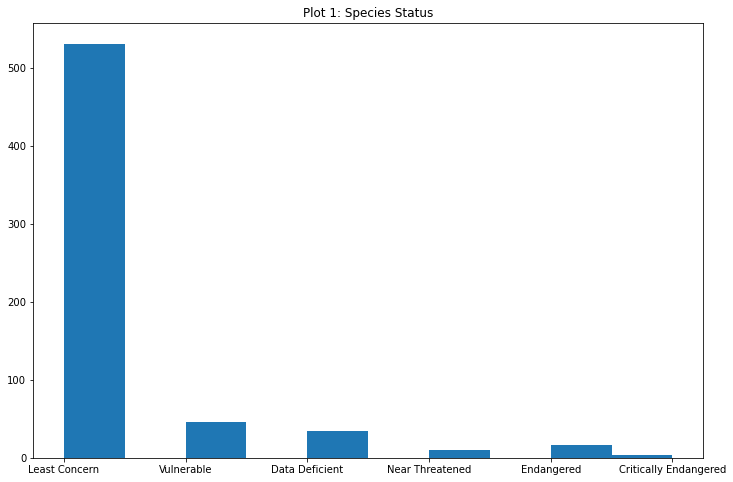

In [37]:
plt.figure(figsize=(12,8))
plt.hist(df.redlistCat)
plt.title('Plot 1: Species Status')

In [26]:
print("The species with the status Critically Endangered are :")
print(df[df.redlistCat=='Critically Endangered'].BINOMIAL)

The species with the status Critically Endangered are :
566    Carcharhinus longimanus
573     Eretmochelys imbricata
631            Pristis pristis
Name: BINOMIAL, dtype: object


- *Carcharhinus longimanus* is Oceanic whitetip shark
- *Eretmochelys imbricata* is Hawksbill sea turtle
- *Pristis pristis* is Largetooth sawfish

<h1> 2. Preliminary calculations </h1> 

In [27]:
area_of_conservation = ACMC.geometry.item()

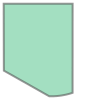

In [28]:
area_of_conservation

<h2> Modulating Factor 1 : Distribution area </h2>

DistRatio 1 = $\frac{\text{total conservation area}}{\text{distribution area}}$

The possible scenarios here would be:

1. `DistRatio 1 > 1` 

`Total conservation area > Distribution area`

Those species can be endemic of ACMC or another site of the ocean or those species have lack spatial information.

2. `DistRatio 1 = 1`

Those species have the same distribution area that ACMC

3. `DistRatio 1 < 1`

`Total conservation area < Distribution area`

Those species have a high spatial coverage.

In [29]:
df['area'] = df.area
df["DistRatio"] = area_of_conservation.area/df.area
df["DistFactorPerc"] = 100*df.DistRatio
df.head().DistRatio

0    0.009522
1    0.009188
2    0.008233
3    0.009871
4    0.012679
Name: DistRatio, dtype: float64

<AxesSubplot:>

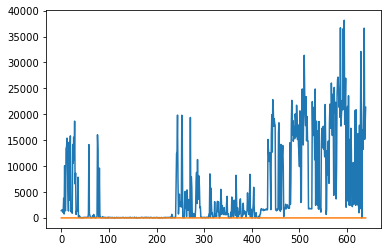

In [116]:
df.geometry.area.plot()
df.DistRatio.plot()

Let's to look more close the Distribution Ratio plot:

<AxesSubplot:>

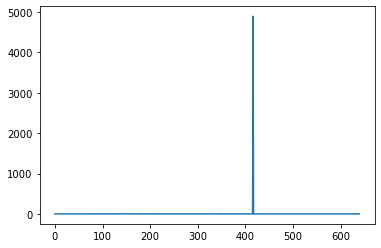

In [31]:
df.DistRatio.plot()

That maximum value are wrong. The dataset needs to be cleaned.

But first, let's to know which species is and its location in our dataset

In [32]:
print('The species is: '+str(df.BINOMIAL[np.where(df.DistRatio == df.DistRatio.max())[0]]))

The species is: 416    Sicydium cocoense
Name: BINOMIAL, dtype: object


The distribution area of the Sicydium cocoense looks like:

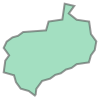

In [33]:
df.loc[416].geometry

TypeError: no numeric data to plot

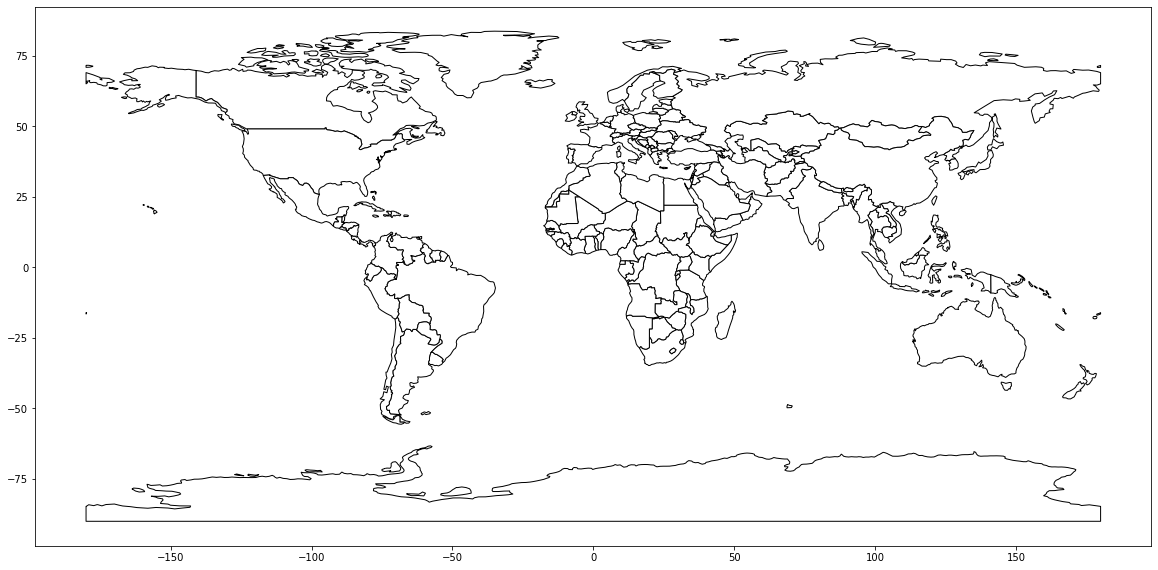

In [34]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


# ax.scatter(Cocos.x, Cocos.y, c = 'r')
#df[df.DistRatio2==np.max(df.DistRatio2)].plot(ax = ax, color = 'r', alpha = 0.25)
df.loc[416].plot(ax = ax, color = 'r', alpha = 0.25)

AMMB_WGS84.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)

ax.set_xlim((-90, -85))
ax.set_ylim((2, 7))
plt.show();

The row 416 is corrupted

In [35]:
df.DistRatio.loc[df['DistRatio'] == df.DistRatio.max()] = np.nan

/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/1941760758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.DistRatio.loc[df['DistRatio'] == df.DistRatio.max()] = np.nan


Let's to plot again distribution ratio:

Text(0.5, 1.0, 'Plot 2: Distribution Ratio 1')

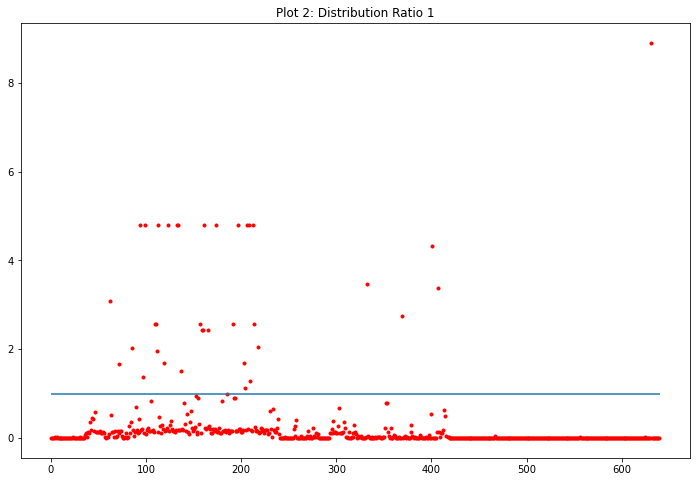

In [48]:
plt.figure(figsize=(12,8))
plt.plot(df.DistRatio,'.r')
plt.hlines(y=1,xmin=0, xmax=640)
plt.title('Plot 2: Distribution Ratio 1')

Text(0.5, 1.0, 'Plot 3: Histogram of Distribution Ratio 1')

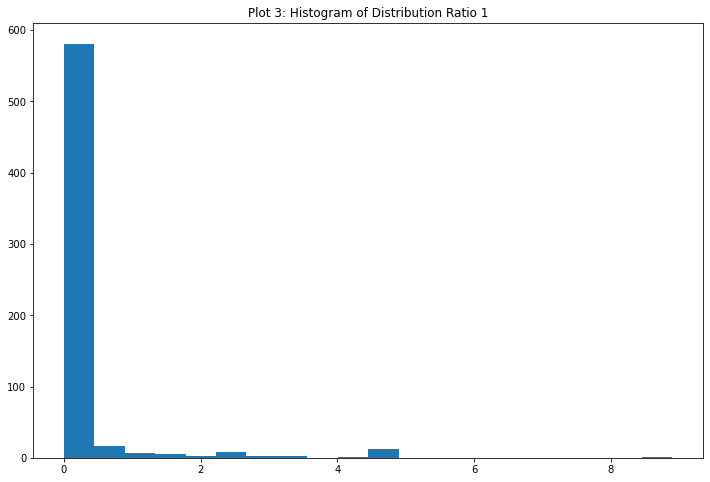

In [55]:
plt.figure(figsize=(12,8))
plt.hist(df.DistRatio,bins=20)
plt.title('Plot 3: Histogram of Distribution Ratio 1')

The plot 3 shows us that we have several species where:

`area of conservation > area of distribution`

then,

`Distribution ratio > 1`

That means that there are species that have their `area of distribution` smallest than the `are of conservation`

But, those areas are only numbers, that species can be endemic in other part of the world.

In addition, it must be taken into account that there may be a lack of information on the distribution of many species.

For example, if they have a small distribution area, it does not imply that they are not in other parts of the world. So it is important to double check what species they are and if the information is correct with reality.

Otherwise, if:

`area of conservation < area of its distribution`

then,

`Distribution ratio < 1`

It means that the area of distribution of that species is biggest than the value of the area of ACMC, so it's less probable those species are endemic of ACMC 

Also, when `Distribution ratio << 1`

It means that those species are migratory species, with a large area of distribution.

With the distribution information, can we have information about hotspots?

------------------------------------------------------------------------------------------------------------
Here, we have a test about the results obtained for Margaux with a old data set and our currently results.

I'm not sure if that value correspond to the same species.

In [49]:
df.loc[[110, 153, 157, 86, 87]].DistRatio

110    2.562393
153    0.142533
157    2.562393
86     0.173024
87     0.050969
Name: DistRatio, dtype: float64

Note:
`df.loc[[110, 153, 157, 86, 87]].DistRatio`
shows
```
110    0.000358
153    0.000409
157    0.000998
86     0.001967
87     0.000718
Name: DistRatio, dtype: float64
```
and
`AMMB_IUCN_df1.head().DistRatio`
showed
```
110    0.000358
153    0.000409
157    0.000998
86     0.001967
87     0.000718
Name: DistRatio, dtype: float64
```

<h2> Modulating Factor 2 : Endemic Species </h2>

Note: Maybe this modulating factor can have another name, because we can obtain more information from it, as local species or migratory species.

DistRatio 2 = $\frac{\text{distribution area within total conservation area}}{\text{total distribution area}}$

Here we can have 3 scenarios:

1. `Distribution Ratio 2 > 1`:This makes no sense because its implies that the distribution area within total conservation area is biggest that its total distribution area
2. `Distribution Ratio 2 = 1`: This implies that those species are endemic and their distribution total area is the same of the ACMC
3. `Distribution Ratio 2 < 1`: 

    3.1 When Distribution `Ratio 2 is close to 1`: This means that those species don't are endemic of ACMC but they are local species (East Central Pacific, e.g)
    
    3.2 When Distribution `Ratio 2 << 1`: Those species are migratory, they visit ACMC seasonally and can travel long distance.

Maps examples: https://towardsdatascience.com/plot-choropleth-maps-with-shapefiles-using-geopandas-a6bf6ade0a49
https://stackoverflow.com/questions/65507374/plotting-a-geopandas-dataframe-using-plotly

In [50]:
# Make new columns
df["DistRatio2"] = 0
df["DistFactorPerc2"] = 0
DistRatio2 = []
DistFactorPerc2 = []

#Method 1:

for iter, row in df.iterrows():
    
    df_intersect = df[df.BINOMIAL==row.BINOMIAL].intersection(area_of_conservation)
    ratio2 = (df_intersect.area/df[df.BINOMIAL==row.BINOMIAL].area).sum()

    DistRatio2.append(ratio2)
    DistFactorPerc2.append(100*ratio2)

In [51]:
df["DistRatio2"] = DistRatio2
df["DistFactorPerc2"] = DistFactorPerc2

In [52]:
# Now remove all geometries that are outside the ACMC -> clip does the job

#Method 2:
df2 = gpd.clip(df.set_crs(epsg=4326, allow_override=True), ACMC)

In [53]:
df2["DistRatio2"] = df2.area/df.area
df2["DistFactorPerc2"] = 100 * df2.DistRatio2

/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/3251184085.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df2["DistRatio2"] = df2.area/df.area


Text(0.5, 1.0, 'Plot 4: Distribution Ratio 2 using two different filtered methods')

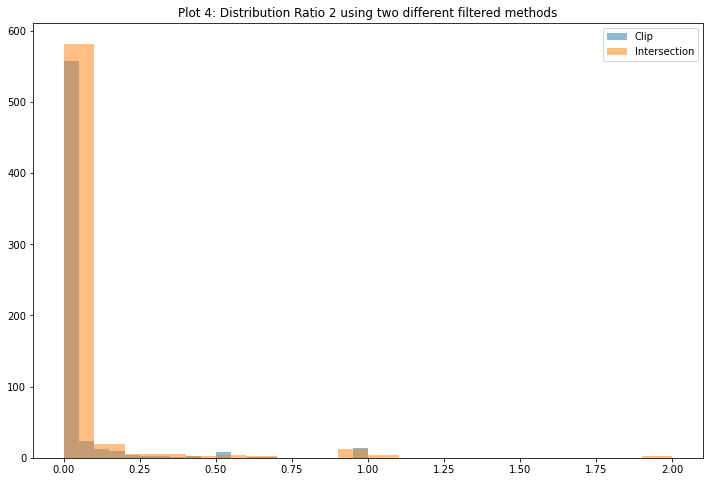

In [105]:
plt.figure(figsize=(12,8))
plt.hist(df2['DistRatio2'],bins=20, alpha=0.5, label = 'Clip')
plt.hist(df['DistRatio2'],bins=20, alpha=0.5, label = 'Intersection')
plt.legend()
plt.title('Plot 4: Distribution Ratio 2 using two different filtered methods')

With the method 1 (Intersection) are species that have: 

$\frac{\text{distribution area within total conservation area}}{\text{total distribution area}} > 1$

and that have not sense in the reality

But, with the method 2 (Clip) that doesn't happen, the maximum value is 1. It's more close to the reality.

Text(0.5, 1.0, 'Plot 5: Distribution Ratio 2 using two different filtered methods')

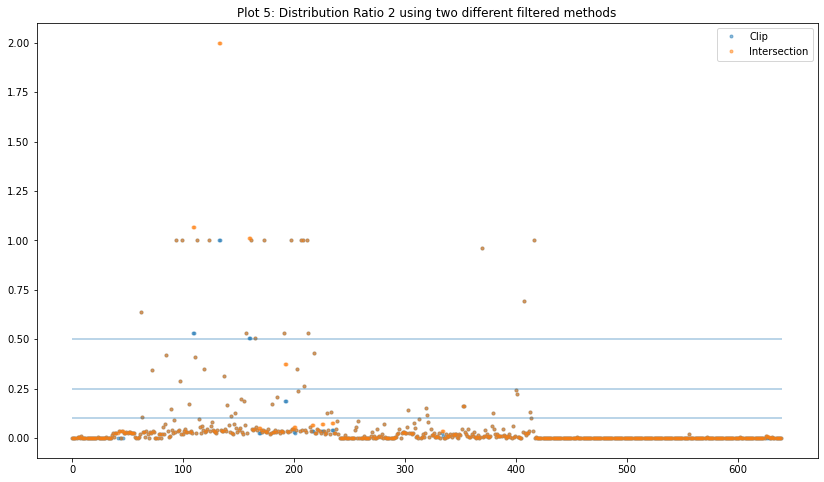

In [123]:
plt.figure(figsize=(14,8))
plt.plot(df2['DistRatio2'],'.', alpha=0.5, label = 'Clip')
plt.plot(df['DistRatio2'],'.', alpha=0.5, label = 'Intersection')
plt.legend()
plt.hlines(y=0.1,xmin=0, xmax=640,alpha=0.4)
plt.hlines(y=0.25,xmin=0, xmax=640,alpha=0.4)
plt.hlines(y=0.5,xmin=0, xmax=640,alpha=0.4)
plt.title('Plot 5: Distribution Ratio 2 using two different filtered methods')

In this plot we can see that:
1. With method 1, the maximum value is 2.
2. With method 2, the maximun value is 1.
3. For both methods, the most of the species has a small distribution ratio 2 [0 - 0.1], it means that the total distribution area is biggest than conservation area (ACMC), so this species could be migratory species.
4. Also, if the species have a distribution ratio 2 between [0.25-0.50], those species could only belong to the Pacific
5. In addition, if distribution ratio 2 is > 0.50, those species could be considered local.

**Here we have the following issue:**

The result to get distribution area within total conservation area per species depends of the method that we use, in this case was 'intersection' and 'clip'.

The method 2 seems to be more appropriate.

Verify:

1) Maximum ratios

Method 1

In [62]:
print("The species with the highest ratio of conservation area with method 1:")
df[df.DistRatio2==np.max(df.DistRatio2)]

The species with the highest ratio of conservation area with method 1:


,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,...,ISLAND,TAX_COMM,redlistCat,scientific,geometry,area,DistRatio,DistFactorPerc,DistRatio2,DistFactorPerc2
132,808,8112889,183433.0,Halichoeres salmofasciatus,1,1,1,IUCN,2009,International Union for Conservation of Nature...,...,None,None,Vulnerable,Halichoeres salmofasciatus,"POLYGON ((-86.13105 5.59887, -86.12913 5.53945...",2.732157,4.806917,480.691733,2.0,200.0
133,809,8112889,183433.0,Halichoeres salmofasciatus,1,1,1,IUCN,2010,International Union for Conservation of Nature...,...,None,None,Vulnerable,Halichoeres salmofasciatus,"POLYGON ((-86.13105 5.59887, -86.12913 5.53945...",2.732157,4.806917,480.691733,2.0,200.0


Let's see what species have `DistRatio2 >= 1` in df

In [63]:
for x in range(len(df)):
    if df.DistRatio2[x] >= 1:
        print('The species is: '+str(df.BINOMIAL[x]))
        print('with DistRatio2: '+str(df.DistRatio2[x]))

The species is: Xyrichtys victori
with DistRatio2: 1.0661271749386128
The species is: Xyrichtys victori
with DistRatio2: 1.0661271749386128
The species is: Halichoeres salmofasciatus
with DistRatio2: 2.0
The species is: Halichoeres salmofasciatus
with DistRatio2: 2.0
The species is: Halichoeres discolor
with DistRatio2: 1.0143868688681699
The species is: Halichoeres discolor
with DistRatio2: 1.0143868688681699
The species is: Ogilbia cocoensis
with DistRatio2: 1.0000000000000009
The species is: Gobiesox woodsi
with DistRatio2: 1.0
The species is: Sicydium cocoense
with DistRatio2: 1.0000000000000002


Method 2

In [64]:
print("The species with the highest ratio of conservation area with method 2:")
df2[df2.DistRatio2==np.max(df2.DistRatio2)]

The species with the highest ratio of conservation area with method 2:


,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,...,ISLAND,TAX_COMM,redlistCat,scientific,geometry,area,DistRatio,DistFactorPerc,DistRatio2,DistFactorPerc2
173,970,8151020,183647.0,Ogilbia cocoensis,1,1,1,IUCN,2010,International Union for Conservation of Nature...,...,None,None,Vulnerable,Ogilbia cocoensis,"POLYGON ((-86.12913 5.53945, -86.12950 5.51332...",2.732156,4.806918,480.691827,1.0,100.0


Let's see what species have `DistRatio2 >= 1` in df2

In [65]:
for x in range(len(df2)):
    if df2.DistRatio2[x] >= 1:
        print('The species is: '+str(df2.BINOMIAL[x]))
        print('with DistRatio2: '+str(df2.DistRatio2[x]))

The species is: Halichoeres salmofasciatus
with DistRatio2: 1.0
The species is: Halichoeres salmofasciatus
with DistRatio2: 1.0
The species is: Ogilbia cocoensis
with DistRatio2: 1.0000000000000009
The species is: Gobiesox woodsi
with DistRatio2: 1.0
The species is: Sicydium cocoense
with DistRatio2: 1.0000000000000002


2) Minimun ratios

Method 1

In [67]:
print("The species with the lowest ratio of conservation area:distribution area is:")
df[df.DistRatio2==np.min(df.DistRatio2)]

The species with the lowest ratio of conservation area:distribution area is:


,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,...,ISLAND,TAX_COMM,redlistCat,scientific,geometry,area,DistRatio,DistFactorPerc,DistRatio2,DistFactorPerc2
312,1982,115223819,154698.0,Lophodolos indicus,1,1,1,SRLI,2010,Sampled Red List Index,...,None,None,Least Concern,Lophodolos indicus,"MULTIPOLYGON (((-107.15026 20.06524, -106.5514...",8497.786124,0.001545,0.154549,0.000008,0.000845


In [68]:
print("The species with the lowest ratio of conservation area:distribution area is:")
df[df.DistRatio2==np.min(df.DistRatio2)]

The species with the lowest ratio of conservation area:distribution area is:


,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,...,ISLAND,TAX_COMM,redlistCat,scientific,geometry,area,DistRatio,DistFactorPerc,DistRatio2,DistFactorPerc2
312,1982,115223819,154698.0,Lophodolos indicus,1,1,1,SRLI,2010,Sampled Red List Index,...,None,None,Least Concern,Lophodolos indicus,"MULTIPOLYGON (((-107.15026 20.06524, -106.5514...",8497.786124,0.001545,0.154549,0.000008,0.000845


Method 2

In [69]:
print("The species with the smallest ratio of conservation area:")
df2[df2.DistRatio2==np.min(df2.DistRatio2)]

The species with the smallest ratio of conservation area:


,index,ASSESSMENT,ID_NO,BINOMIAL,PRESENCE,ORIGIN,SEASONAL,COMPILER,YEAR,CITATION,...,ISLAND,TAX_COMM,redlistCat,scientific,geometry,area,DistRatio,DistFactorPerc,DistRatio2,DistFactorPerc2
312,1982,115223819,154698.0,Lophodolos indicus,1,1,1,SRLI,2010,Sampled Red List Index,...,None,None,Least Concern,Lophodolos indicus,"POLYGON ((-88.94648 6.53217, -89.32126 6.23234...",8497.786124,0.001545,0.154549,0.000008,0.000845


In this case, it has the same species with the smallest ratio of conservation area

Comparing..

In [73]:
print("Species distratio2, v1:")
print(df[df.ID_NO==183433.0].DistRatio2)
print(df[df.ID_NO==183433.0].BINOMIAL)
print("Species distratio2, v2:")
print(df2[df2.ID_NO==183433.0].DistRatio2)
print(df2[df2.ID_NO==183433.0].BINOMIAL)

Species distratio2, v1:
132    2.0
133    2.0
Name: DistRatio2, dtype: float64
132    Halichoeres salmofasciatus
133    Halichoeres salmofasciatus
Name: BINOMIAL, dtype: object
Species distratio2, v2:
132    1.0
133    1.0
Name: DistRatio2, dtype: float64
132    Halichoeres salmofasciatus
133    Halichoeres salmofasciatus
Name: BINOMIAL, dtype: object


In [74]:
print("Species distratio2, v1:")
print(df[df.ID_NO==60324.0].DistRatio2)
print(df[df.ID_NO==60324.0].BINOMIAL)
print("Species distratio2, v2:")
print(df2[df2.ID_NO==60324.0].DistRatio2)
print(df2[df2.ID_NO==60324.0].BINOMIAL)

Species distratio2, v1:
467    0.00001
Name: DistRatio2, dtype: float64
467    Chanos chanos
Name: BINOMIAL, dtype: object
Species distratio2, v2:
467    0.00001
Name: DistRatio2, dtype: float64
467    Chanos chanos
Name: BINOMIAL, dtype: object


In [75]:
print("Species distratio2, v1:")
print(df[df.ID_NO==39375.0].DistRatio2)
print(df[df.ID_NO==39375.0].BINOMIAL)
print("Species distratio2, v2:")
print(df2[df2.ID_NO==39375.0].DistRatio2)
print(df2[df2.ID_NO==39375.0].BINOMIAL)

Species distratio2, v1:
280    0.000009
Name: DistRatio2, dtype: float64
280    Carcharhinus melanopterus
Name: BINOMIAL, dtype: object
Species distratio2, v2:
280    0.000009
Name: DistRatio2, dtype: float64
280    Carcharhinus melanopterus
Name: BINOMIAL, dtype: object


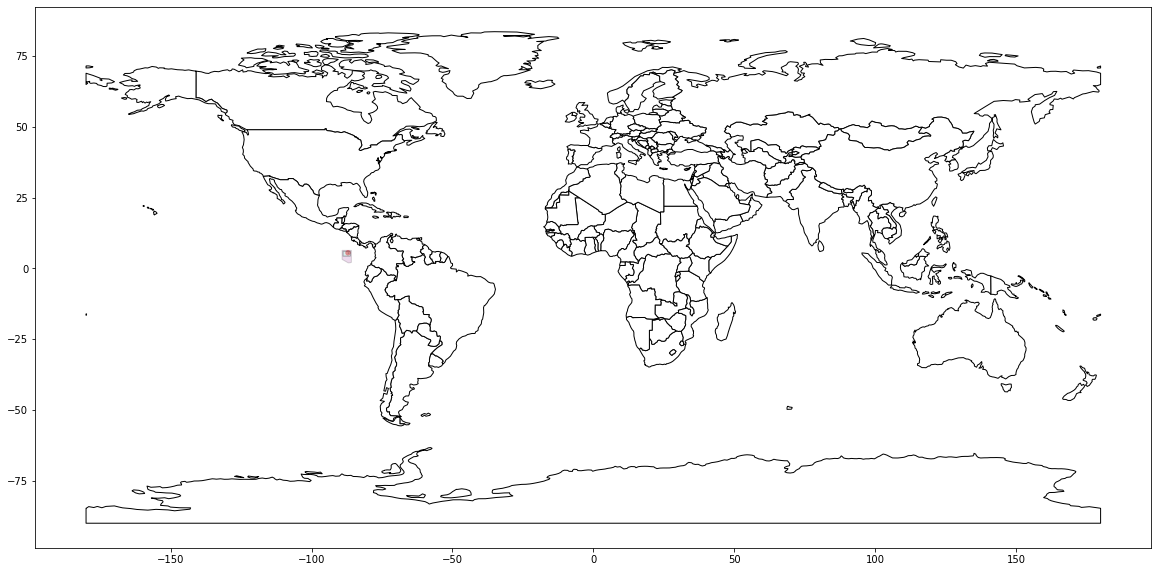

In [76]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df[df.DistRatio2==np.max(df.DistRatio2)].plot(ax = ax, color = 'r', alpha = 0.25)

AMMB_WGS84.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)

#ax.set_xlim((-110, -60))
#ax.set_ylim((-50, 60))
plt.show();

Let's see more close to ACMC:

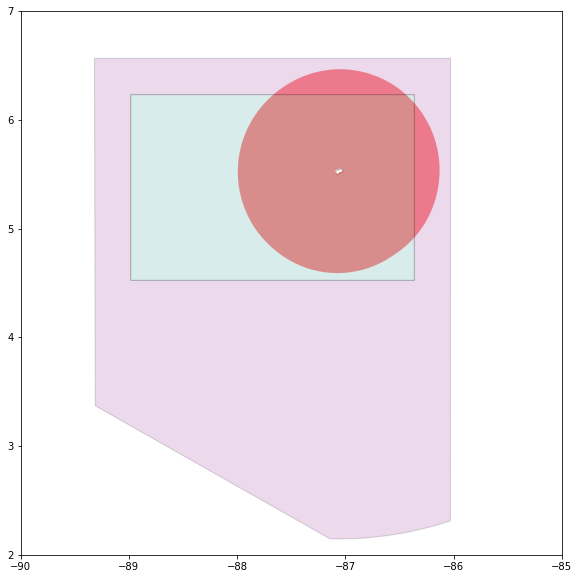

In [77]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df[df.DistRatio2==np.max(df.DistRatio2)].plot(ax = ax, color = 'r', alpha = 0.25)

AMMB_WGS84.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)

ax.set_xlim((-90, -85))
ax.set_ylim((2, 7))
plt.show();

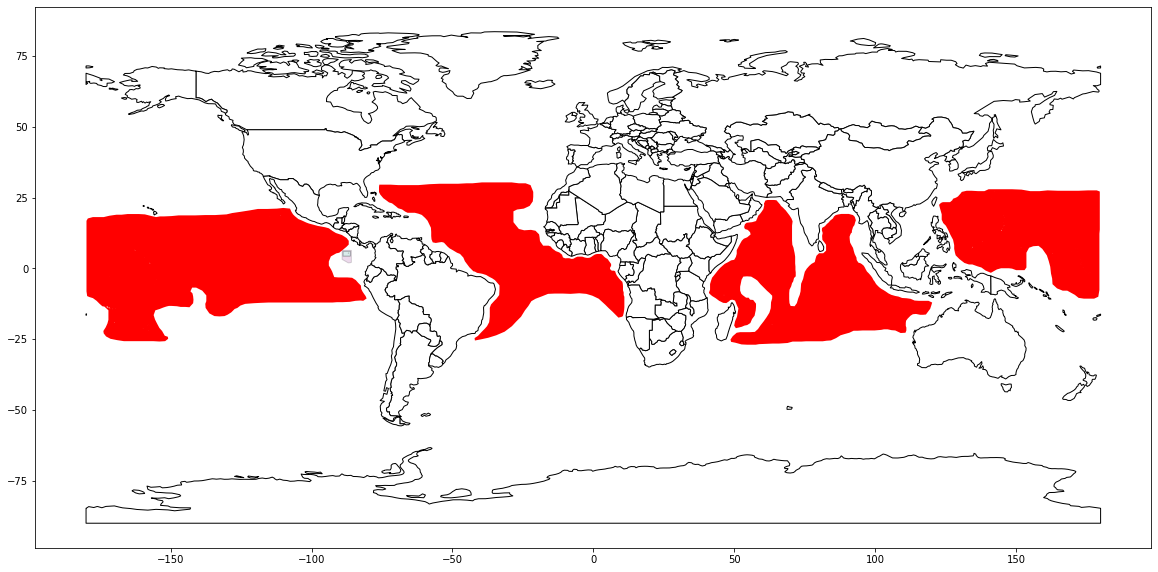

In [78]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df[df.DistRatio2==np.min(df.DistRatio2)].plot(ax = ax, color = 'r', alpha = 1)

AMMB_WGS84.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)


#ax.set_xlim((-90, -80))
#ax.set_ylim((0, 10))
plt.show();

Let's see more close to ACMC:

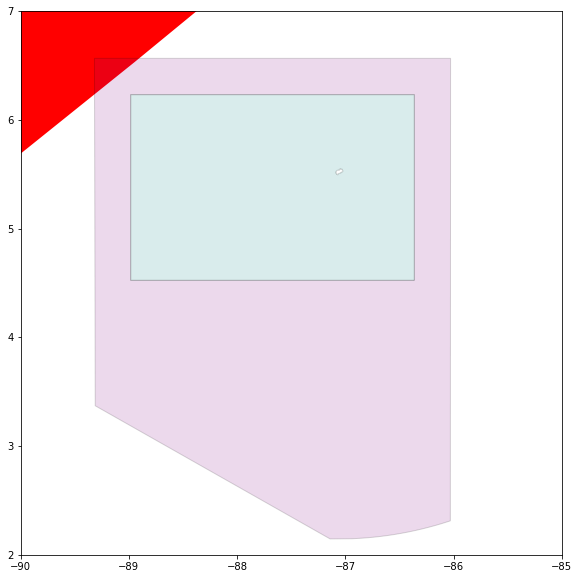

In [79]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')


# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df[df.DistRatio2==np.min(df.DistRatio2)].plot(ax = ax, color = 'r', alpha = 1)

AMMB_WGS84.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)

ax.set_xlim((-90, -85))
ax.set_ylim((2, 7))
plt.show();

<h2> Modulating Factor 3 : Species Richness </h2>

That is: use the total number of species within the area of interest to get the base credit.

Info from SINAC, link to [Google Drive](https://drive.google.com/file/d/1Bztf55bKgZi7X9nJPbWGdOUtW7Zv0-3_/view?usp=sharing) document
```
The CINP is home to 1688 species of marine fauna, of which
45 are endemic. This represents 47,4 % of the endemism in
Costa Rica. In other words, the CINP contributes half of the
country’s unique biological richness.
```
SINAC (Sistema Nacional de Áreas de Conservación). 2018. Importancia de los ecosistemas y las poblaciones del sitio de interés: Parque Nacional Isla del Coco (PNIC), Área Marina de Manejo Montes Submarinos (AMM MS) y aguas adyacentes. Área de Conservación Marina Cocos. San José, Costa Rica. 68 p.

Note: this was the old park
```
The CINP, created in 1978, is located 342 miles (500 km) southeast of Costa Rica’s Pacific coast and covers an area of 785 sq miles (2034 km2). The island comprises an area of about 9 sq miles (23 km2) and the marine area covers the remaining 776 sq miles (2011 km2). The SMMA was created in 2011 and was the first protected wildlife area in this category in Costa Rica. It encompasses 3725 sq miles (9649 km2) of the Pacific Ocean waters around the CINP (Figure 1).
```

Note: World Register of Marine Species (WoRMS)  contains 243,000 species in its inventory.

https://en.wikipedia.org/wiki/Marine_life#/media/File:Marine_animal_biodiversity.png shows 201,004.

https://en.wikipedia.org/wiki/Species_richness shows species richness in terms of km? or per sq km?

https://www.researchgate.net/figure/Global-marine-species-richness-for-all-taxa-Source-Titterson-et-al-2010_fig2_305636318
this is at a coarse resolution, but we can use this to normalize marine richness?

According to: https://www.researchgate.net/publication/45406822_Global_patterns_and_predictors_of_marine_biodiversity_across_taxa
we have: 
11,567 total - 60 seagrasses - 32 mangroves - 39 foraminifera

**Marine biodiversity Assumption 1**

Assuming a total number of species of marine fauna of $N_\text{total}$ (here `N_species_fauna_total`)

In [80]:
N_species_fauna_total = 11567 - 60 - 32 - 39
print(N_species_fauna_total)

11436


**Marine biodiversity Assumption 2**

Assuming a number of species of marine fauna within the area of interest of $N_\text{local}$ (here `N_species_fauna`). This is extrapolating the number of species given by SINAC to the entire ACMC area.

In [81]:
N_species_fauna = 1688

**Marine biodiversity Assumption 3**

The marine fauna is uniformely distributed accross the ACMC... here because we don't have:
- $N_\text{local}$(square kilometer 1)
- $N_\text{local}$(square kilometer 2)
- ...
- $N_\text{local}$(square kilometer  N)

Thus our "base unit" for credits is homogeneous throughout ACMC. 

Note 1: this is for illustrative purposes and this is a WRONG assumption! but we do not have a heat map of marine fauna!

Note 2: another approach can be that the representativeness of biodiversity in ACMC with respect to the world total. Value that can be penalized for the lack of data in ACMC.

In [85]:
N_units_base = np.exp(N_species_fauna/N_species_fauna_total)
print(N_units_base)

1.1590538866455768


Assuming we had the maximum species richness of $N_\text{total}$ = 2,555 (here `N_species_fauna_total`):

In [86]:
np.exp(2555/N_species_fauna_total)

1.2503422061517109

That's the "maximum base unit" per this logic.

Assuming we have very little species richness, e.g. $N_\text{total}$ = 10 (here `N_species_fauna_total` means there are only 10 species of fish, crabs, whatever):

In [87]:
np.exp(10/N_species_fauna_total)

1.0008748140462365

That's a lower bound for the "base unit" per this logic.

It is a very narrow range that does not reward high biodiversity this much. 

Is it "good" or "bad"? 

Note: 

Well, the advantages are as follows:
   * it minimizes the impact of measurements errors and uncertainty. Given that measuring marine biodiversity is difficult, this may actually be a good thing.
    
   * it increases the influence of modulating factors, such as:
        - vulnerable species
        - endemism
        - habitat type
        - etc.

<h2> Modulating Factor 4 : Habitat type  </h2>

### Physical habitat types

Depth-defined marine ecological habitats
- epipelagic: 0-200m
- mesopelagic: 200-1000m
- bathypelagic: 1000-4000m
- abyssipelagic: 4000-6000m

**Bathymetry data**

In [130]:
fname = "/Users/maureenfonseca/Desktop/OEF/Bathymetry/Cocos.nc"
fh = Dataset(fname, 'r')

Import the specific variables.

In [131]:
Z = fh.variables["elevation"][:].data
lon = fh.variables["lon"][:].data
lat = fh.variables["lat"][:].data

Grid longitude and latitude for pcolor plot.

In [132]:
Lon, Lat = np.meshgrid(lon, lat)

The idea here is eliminate all the value > 0, i.e, we want to have only values for the ocean

In [133]:
ocean = np.multiply(Z,np.multiply(Z<=0, Z>np.min(Z)))
bathymetry = np.where(ocean==0, np.nan, ocean)

Let's go to make a function that calculates the different physical habitats

where z_0 is the shallowest depth

In [134]:
def physicalHabitat(z_0,z_1,z):
    Filter = np.multiply(z,np.multiply(z<=z_0, z>z_1))
    habitat = np.where(Filter==0, np.nan, Filter)
return habitat

In [135]:
epipelagic = physicalHabitat(0,-200,bathymetry)
mesopelagic = physicalHabitat(-200,-1000,bathymetry)
bathypelagic = physicalHabitat(-1000,-4000,bathymetry)
abyssopelagic = physicalHabitat(-4000,-6000,bathymetry)

**Plots**

Text(1.0, 1.0, 'ACMC')

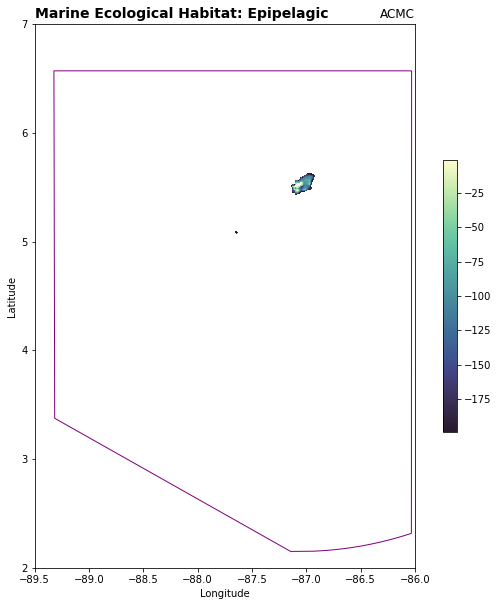

In [136]:
fig, ax = plt.subplots(figsize=(10,10))

pcol = ax.pcolor(Lon, Lat, epipelagic, cmap = cmocean.cm.deep_r);
cbar = fig.colorbar(pcol, ax=ax, shrink=0.5)

ACMC.plot(ax=ax, alpha = 1, edgecolor='purple', facecolor="none")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
ax.set_title('Marine Ecological Habitat: Epipelagic', fontweight='bold', fontsize=14, loc='left')
ax.set_title('ACMC', fontsize=12, loc='right')

Text(1.0, 1.0, 'ACMC')

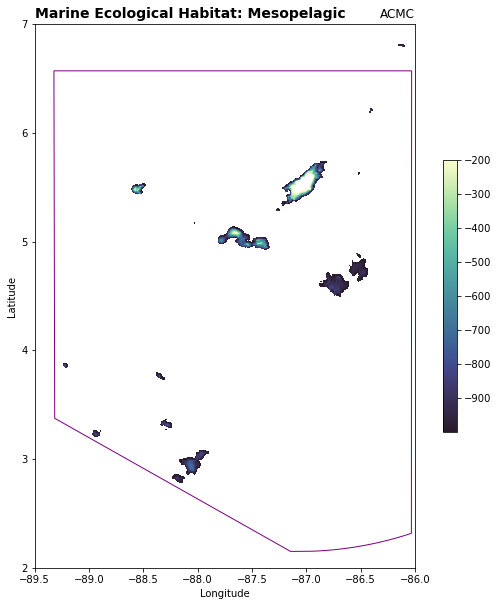

In [137]:
fig, ax = plt.subplots(figsize=(10,10))

pcol = ax.pcolor(Lon, Lat, mesopelagic, cmap = cmocean.cm.deep_r);
cbar = fig.colorbar(pcol, ax=ax, shrink=0.5)

ACMC.plot(ax=ax, alpha = 1, edgecolor='purple', facecolor="none")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
ax.set_title('Marine Ecological Habitat: Mesopelagic', fontweight='bold', fontsize=14, loc='left')
ax.set_title('ACMC', fontsize=12, loc='right')

Text(1.0, 1.0, 'ACMC')

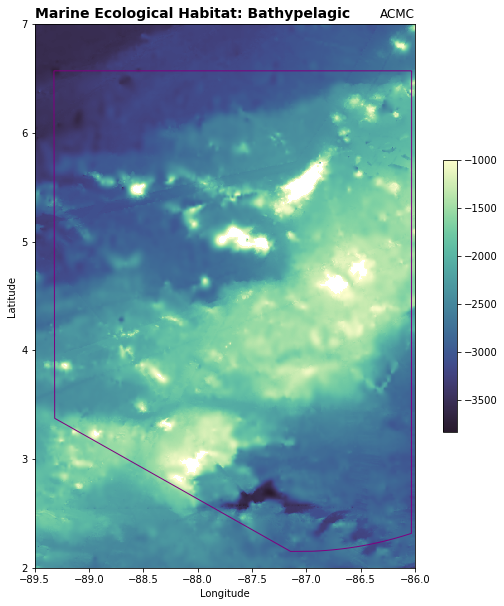

In [138]:
fig, ax = plt.subplots(figsize=(10,10))

pcol = ax.pcolor(Lon, Lat, bathypelagic, cmap = cmocean.cm.deep_r);
cbar = fig.colorbar(pcol, ax=ax, shrink=0.5)

ACMC.plot(ax=ax, alpha = 1, edgecolor='purple', facecolor="none")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
ax.set_title('Marine Ecological Habitat: Bathypelagic', fontweight='bold', fontsize=14, loc='left')
ax.set_title('ACMC', fontsize=12, loc='right')

Text(1.0, 1.0, 'ACMC')

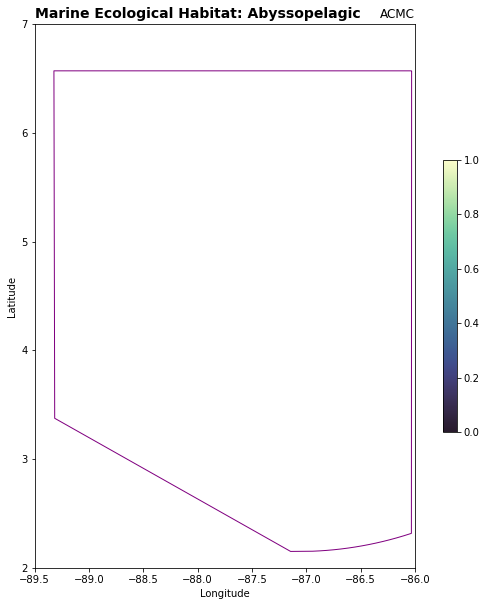

In [139]:
fig, ax = plt.subplots(figsize=(10,10))

pcol = ax.pcolor(Lon, Lat, abyssopelagic, cmap = cmocean.cm.deep_r);
cbar = fig.colorbar(pcol, ax=ax, shrink=0.5)

ACMC.plot(ax=ax, alpha = 1, edgecolor='purple', facecolor="none")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
ax.set_title('Marine Ecological Habitat: Abyssopelagic', fontweight='bold', fontsize=14, loc='left')
ax.set_title('ACMC', fontsize=12, loc='right')

So, with the lasts plots we can see the physical habitats in ACMC, where the open ocean predomin.

### Seamounts and Knolls

Seamounts and knolls are typically formed by volcanic activity. 

Seamounts rise at least 1,000 meters above the seafloor, whereas the height of knolls is smaller and ranges from approximately 500 to 1000 meters.

**Seamounts data**

In [149]:
seamounts = gpd.read_file('../../SeamountsBaseArea/SeamountsBaseArea.shp')

In [151]:
# Ignore warning about missing/empty geometries

import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

Overlap with ACMC

In [152]:
df1 = gpd.GeoDataFrame(columns = seamounts.columns)

In [153]:
print("We start with a df of length " + str(len(seamounts)))
for idj in range(0, len(seamounts)):
    try:
        if seamounts.loc[idj].geometry.overlaps(ACMC.geometry.item()):
            df1 = df1.append(seamounts.loc[idj])
    except:
        try:
            if seamounts.loc[idj].geometry.buffer(0).overlaps(ACMC.geometry.item()):
                df1 = df1.append(seamounts.loc[idj])
        except:
            print("Issue at row " + str(idj))
            pass   
print("We end with a df of length " + str(len(df1)))

We start with a df of length 33452


/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/3536281104.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/3536281104.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



We end with a df of length 2


In [154]:
print('Total seamounts area in ACMC: '+str(np.sum(df1.AREA2D)))
print('ACMC area: '+str(ACMC.area_km))

Total seamounts area in ACMC: 1366.4720118629991
ACMC area: 0    106283.651423
Name: area_km, dtype: float64


**Knolls data**

In [150]:
knolls = gpd.read_file('../../KnollsBaseArea/KnollsBaseArea.shp')

Overlap with ACMC

In [155]:
df2 = gpd.GeoDataFrame(columns = knolls.columns)

In [156]:
print("We start with a df of length " + str(len(knolls)))
for idj in range(0, len(knolls)):
    try:
        if knolls.loc[idj].geometry.overlaps(ACMC.geometry.item()):
            df2 = df2.append(knolls.loc[idj])
    except:
        try:
            if knolls.loc[idj].geometry.buffer(0).overlaps(ACMC.geometry.item()):
                df2 = df2.append(knolls.loc[idj])
        except:
            print("Issue at row " + str(idj))
            pass   
print("We end with a df of length " + str(len(df2)))

We start with a df of length 138412


/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/3214930105.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/3214930105.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/3214930105.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/3214930105.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/v8/b0fnjf9d4q31sfz_8q4h4zxm0000gn/T/ipykernel_9053/3214930105.py:5: FutureWarning:

The frame.append method is deprecated a

We end with a df of length 31


In [157]:
print('Total seamounts area in ACMC: '+str(np.sum(df2.AREA2D)))
print('ACMC area: '+str(ACMC.area_km))

Total seamounts area in ACMC: 22551.034606837005
ACMC area: 0    106283.651423
Name: area_km, dtype: float64


<h2> Modulating Factor 5 : Conservation Status - Vulnerable Species </h2>

We have the following conservation statuses:

In [ ]:
print("The species with the status Critically Endangered are :")
print(df_nonan[df_nonan.redlistCategory=='Critically Endangered'].BINOMIAL)

- *Carcharhinus longimanus* is Oceanic whitetip shark
- *Eretmochelys imbricata* is Hawksbill sea turtle
- *Pristis pristis* is Largetooth sawfish

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')

AMMB.plot(ax=ax, alpha = 0.15, color = 'purple', edgecolor='black')

PNIC_WGS84.plot(ax=ax, alpha = 0.15, color = 'teal', edgecolor='black')#, marker='o', color='red', markersize=5)

# ax.scatter(Cocos.x, Cocos.y, c = 'r')
df_nonan[df_nonan.DistRatio2==np.min(df_nonan.DistRatio2)].plot(ax = ax, color = 'r')

ax.set_xlim((-90, -85))
ax.set_ylim((2, 7))
plt.show();

To be honest, I'm not sure which road to take. On the one hand, it seems more *logical* to use the second option in terms of distribution area:
- the conservation area (AMMB) is HUGE compared to the range of the sawfish
- but within AMMB, the sawfish is not widely distributed.
- vice-versa for the ray

On the other hand:
- the region around AMMB seem way more critical for the sawfish than the ray: see how distributed the ray is?
- the conservation for the milkfish is diminished compared to the orca.

so perhaps the first route was the "right" one?

In any case, we need some post-processing, e.g. smoothing, clustering, etc.

In [ ]:
def get_DistRatioFactor_invsquare(DistRatio, print_out = False):
    # This function calculates the weighted endemism of species by taking the sum of the 
    # squares of the ratios of (area conserved / total distribution area)
    #
    # Input arguments:
    #      DistRatio: a series of the area conserved / total distribution area ratio for each species
    #      print_out: a boolean for printing out the factor
    #
    # Output:
    #      factor: the factor of weighted endemism
    
    factor = 1+sum(DistRatio**2)
    if print_out:
        print("We multiply N credits by " + "{:0.3f}".format(factor))
    return factor

**First approach**

What are the credits based on DistRatio1?

In [ ]:
example_credits(area_of_conservation.area, df_nonan.DistRatio, get_DistRatioFactor);
example_credits(111.1**(-2), df_nonan.DistRatio, get_DistRatioFactor);

example_credits(area_of_conservation.area, df_nonan.DistRatio, get_DistRatioFactor_square);
example_credits(111.1**(-2), df_nonan.DistRatio, get_DistRatioFactor_square);

Okay clearly these numbers get wild.

**Second approach**

What are the credits based on DistRatio2?

In [ ]:
example_credits(area_of_conservation.area, df_nonan.DistRatio2, get_DistRatioFactor);
example_credits(111.1**(-2), df_nonan.DistRatio2, get_DistRatioFactor);

example_credits(area_of_conservation.area, df_nonan.DistRatio2, get_DistRatioFactor_square);
example_credits(111.1**(-2), df_nonan.DistRatio2, get_DistRatioFactor_square);

Okay for the order of magnitude, so-so for what it represents.

Wild card:

In [ ]:
example_credits(area_of_conservation.area, df_nonan.DistRatio, get_DistRatioFactor_invsquare);
example_credits(111.1**(-2), df_nonan.DistRatio, get_DistRatioFactor);

We will need to check this out with "smoothing".

... to be continued.

It seems like a fairer approach.

<h2> Modulating Factor 6 :  </h2>

<h1> 3. Marine Biodiversity Unit </h1>

i.e. we create a base unit and we modulate it with different adjustments: vulnerability, distribution range, etc.

<h2> Base Unit</h2>

This is where we get a biodiversity index for the area. Example:

- get the Shannon index over ACMC
- get another biodiversity score that we normalize against a global score

<h3> Example: Shannon Biodiversity </h3>

The maximum Shannon biodiversity index worldwide is ~8.5.

E.g. around Cocos Island, based on OBIS data (...), a Shannon biodiversity index of 6.25 over 160,000 km$^2$ would give

base credit $ = \frac{6.25 \text{ (local index)}}{8.5 \text{ (max global index)}}) = $ 0.735

total credits = $\frac{6.25 \text{ (local index)}}{8.5 \text{ (max global index)}})\times 160,000 \text{ km}^2 \times \frac{1\text{ Marine Biodiversity Unit}}{1 \text {km}^2} = $ 117,647 Marine Biodiversity Units

That gives the baseline. To be completed. 

Note: we CANNOT get the Shannon index just from IUCN data. We need the number of specimens for each species.

<h3> Example: Physical Habitats </h3>

Thinking that we have 4 possible habitats when the bathymetry is considered, we can score them per amount of habitats. The propose is:

Epipelagic: 1

Mesopelagic: 2

Bathypelagic: 3

Abyssipelagic: 4

Then,

In [140]:
bathymetry2 = bathymetry.copy()

Let's go to assign a value per physical habitat

In [146]:
for x in range(1200):
    for y in range(840):
        if bathymetry2[x][y]>=-200:
            bathymetry2[x][y] = 1
        elif bathymetry2[x][y]>=-1000:
            bathymetry2[x][y] = 2
        elif bathymetry2[x][y]>=-4000:
            bathymetry2[x][y] = 3
        elif bathymetry2[x][y]>=-6000:
            bathymetry2[x][y] = 4

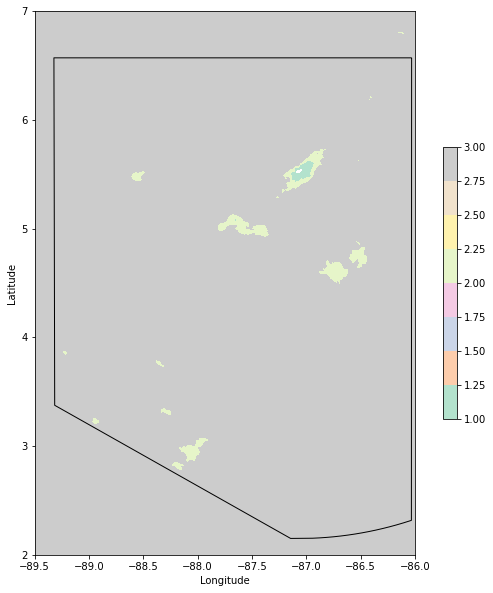

In [147]:
fig, ax = plt.subplots(figsize=(10,10))

pcol = ax.pcolor(Lon, Lat, bathymetry2, cmap = 'Pastel2');
cbar = fig.colorbar(pcol, ax=ax, shrink=0.5)

ACMC.plot(ax=ax, alpha = 1, facecolor="none")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')

### Assigning MBU units

*This part should to be check

Physical Habitats base credit $ = (\frac{\text{local scoring}}{\text{max global scoring}})$

total credits per Epipelagic Habitat = $\frac{1 \text{ (local scoring)}}{4 \text{ (max global scoring)}})\times \text{Total Area}\times \frac{1\text{ Marine Biodiversity Unit}}{1 \text {km}^2} = $ XXX MBU

total credits per Mesopelagic Habitat = $\frac{2 \text{ (local scoring)}}{4 \text{ (max global scoring)}})\times \text{Total Area}\times \frac{1\text{ Marine Biodiversity Unit}}{1 \text {km}^2} = $ YYY MBU

total credits per Epipelagic Habitat = $\frac{3 \text{ (local scoring)}}{4 \text{ (max global scoring)}})\times \text{Total Area}\times \frac{1\text{ Marine Biodiversity Unit}}{1 \text {km}^2} = $ ZZZ MBU

Here, for `total area`, I have two ideas:

    1. Total Area = Physical Habitat area in ACMC
    
    2. Total Area = ACMC area

<h3> Example: Seamounts and Knolls </h3>

**First proposal**

How we are creating a Global Marine Biodiversity Unit, it's necessary normalized our metrics with a global reference, then, if can have the global area of seamounts and knolls

In [160]:
global_seamount_area = np.sum(seamounts.AREA2D)
global_knolls_area = np.sum(knolls.AREA2D)

ACMC_seamount_area = np.sum(df1.AREA2D)
ACMC_knolls_area = np.sum(df2.AREA2D)

In [161]:
print('Global seamounts area: '+str(global_seamount_area))
print('Global knolls area: '+str(global_knolls_area))

print('ACMC seamounts area: '+str(ACMC_seamount_area))
print('ACMC knolls area: '+str(ACMC_knolls_area))

print('ACMC area: '+str(ACMC.area_km))

Global seamounts area: 26944516.81308316
Global knolls area: 91681440.42388554
ACMC seamounts area: 1366.4720118629991
ACMC knolls area: 22551.034606837005
ACMC area: 0    106283.651423
Name: area_km, dtype: float64


In [163]:
base_credit_seamounts = (ACMC_seamount_area/global_seamount_area)
base_credit_knolls = (ACMC_knolls_area/global_knolls_area)

print('Base Credit Seamounts: ' + str(base_credit_seamounts))
print('Base Credit Knolls: ' + str(base_credit_knolls))

Base Credit Seamounts: 5.0714288971754575e-05
Base Credit Knolls: 0.0002459716437980597


I'm not sure if this approach is useful.

Well, let's see the amount of credits:

**Assigning MBU units**

Total Credits Seamount = $\frac{\text{ACMC Seamounts Area}}{\text{Global Seamounts Area}}\times\text{ACMC area}\times \frac{1\text{ Marine Biodiversity Unit}}{1 \text {km}^2} = $ XXX MBU

Total Credits Knolls = $\frac{\text{ACMC Knolls Area}}{\text{Global Knolls Area}}\times\text{ACMC area}\times \frac{1\text{ Marine Biodiversity Unit}}{1 \text {km}^2} = $ YYY MBU

In [164]:
Total_Credits_Seamount = base_credit_seamounts*ACMC.area_km
Total_Credits_Knolls = base_credit_knolls*ACMC.area_km

print('Total Credits Seamounts: ' + str(Total_Credits_Seamount))
print('Total Credits Knolls: ' + str(Total_Credits_Knolls))

Total Credits Seamounts: 0    5.3901
Name: area_km, dtype: float64
Total Credits Knolls: 0    26.142764
Name: area_km, dtype: float64


**Second proposal**

We might not consider the global area, only the local one.

**Assigning MBU units**

Total Credits Seamount = $\frac{\text{ACMC Seamounts Area}}{\text{ACMC area}}\times\text{ACMC area}\times \frac{1\text{ Marine Biodiversity Unit}}{1 \text {km}^2} = $ XXX MBU

Total Credits Knolls = $\frac{\text{ACMC Knolls Area}}{\text{ACMC area}}\times\text{ACMC area}\times \frac{1\text{ Marine Biodiversity Unit}}{1 \text {km}^2} = $ YYY MBU

In [167]:
Total_Credits_Seamount2 = (ACMC_seamount_area/ACMC.area_km)*ACMC.area_km
Total_Credits_Knolls2 = (ACMC_knolls_area/ACMC.area_km)*ACMC.area_km

print('Total Credits Seamounts: ' + str(Total_Credits_Seamount2))
print('Total Credits Knolls: ' + str(Total_Credits_Knolls2))

Total Credits Seamounts: 0    1366.472012
Name: area_km, dtype: float64
Total Credits Knolls: 0    22551.034607
Name: area_km, dtype: float64


Those numbers are more significant, however I'm not sure if they make sense.

One of the reasons why the ACMC was enlarged was due to the presence of seamounts, which have a positive impact on ecosystems and biodiversity due to the dynamics with marine currents.

**Notes**

1. In those approaches, I'm not consider each sqkm, it's more general for the whole ACMC area.
2. For the Habitats Type approach, I need to calculate the area per physical habitat to do the same process